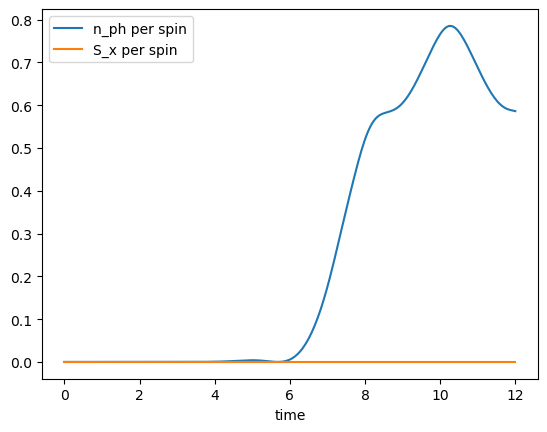

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve

# -------------------------
# parameters
N = 6          # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

# -------------------------
# time-dependence
def g_t(t, args):
    g0 = args.get('g0', 2.0)
    t0 = args.get('t0', 5.0)
    tau = args.get('tau', 1.0)
    return g0 * 0.5 * (1 + np.tanh((t - t0)/tau))

def gdot_t(t, args):
    g0 = args.get('g0', 2.0)
    t0 = args.get('t0', 5.0)
    tau = args.get('tau', 1.0)
    return g0 * 0.5 * (1 - np.tanh((t - t0)/tau)**2) / tau

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)

# Hamiltonian list for sesolve
H_td = [[V, coeff]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 0), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)

# evolve
tlist = np.linspace(0, 12, 300)
args = {'g0': 2.0, 't0': 5.0, 'tau': 1.0}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N

# plot
plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.xlabel("time")
plt.legend()
plt.show()


## We consider a sinusoidal transverse periodic external field

Trial: Bessel function type of root

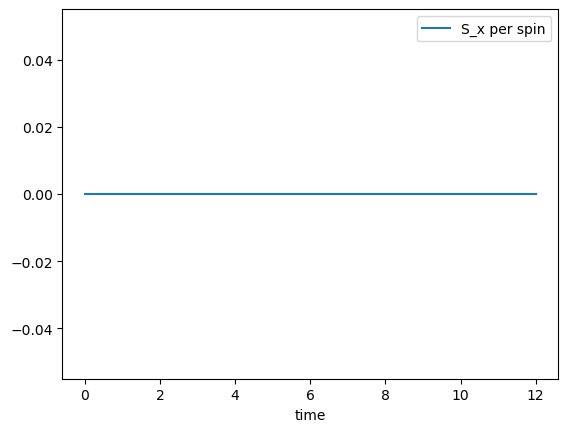

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

# -------------------------
# parameters
N = 3         # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

# -------------------------
# parameters
N = 3         # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

# -------------------------
# -------------------------
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''

def g_t(t, args):
    g0 = args.get('g0', jn_zeros( 0, 2)[0] * 10/2)
    w = args.get('omega', 10.0)
    return g0 * np.sin(w * t)

def gdot_t(t, args):
    g0 = args.get('g0', 2.0)
    w = args.get('omega', 10.0)
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)

# Hamiltonian list for sesolve
H_td = [[V, coeff]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 0), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)

# evolve
tlist = np.linspace(0, 12, 300)
args = {'omega': 10.0, 'g0': jn_zeros( 0, 2)[0] * 10/2}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N

# plot
#plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.xlabel("time")
plt.legend()
plt.show()